# Data for Everyone - Natural Disaster terms
Exploring three data sets to see relevant words used when talking about natural disasters. 
1. Tweets and whether they are relevant to a natural disaster [Jump](#tweets)
    - tone of these tweets are more news like than like a help request as in OWL
    - keyword list could be useful, but need to be sorted
    - also includes a possible OWL message 
2. Paired terms: is this term relevant for topic [Jump](#paired)
    - good source of terms: medical list stood out in particular
    - issue is how to utilize these terms - how many would we actually see in OWL messages?
    - need 
3. More paired terms [Jump](#relief)
    - 
Data Source: https://www.figure-eight.com/data-for-everyone/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

import spacy
import wordninja # split words that are missing spaces in between 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS
import string
import pickle

<a id='tweets'></a>
# Natural Disaster Tweets

In [2]:
sm = pd.read_csv('./data/socialmedia-disaster-tweets-DFE.csv', encoding='latin-1') # a simple encoding to ignore complex characters

In [3]:
sm.shape

(10876, 13)

In [4]:
sm.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


In [5]:
sm.nunique()

_unit_id                 10876
_golden                      2
_unit_state                  2
_trusted_judgments          45
_last_judgment_at          696
choose_one                   3
choose_one:confidence      463
choose_one_gold              4
keyword                    221
location                  4521
text                     10678
tweetid                   1243
userid                    9781
dtype: int64

In [6]:
sm.dtypes

_unit_id                   int64
_golden                     bool
_unit_state               object
_trusted_judgments         int64
_last_judgment_at         object
choose_one                object
choose_one:confidence    float64
choose_one_gold           object
keyword                   object
location                  object
text                      object
tweetid                  float64
userid                   float64
dtype: object

### Figure out what individual columns are
Relevant means tweet relevant to a natural disaster event. Not relevant if used jokingly or in other manners.
DATA_DICT:
1. _unit_id: int, primary key
2. _golden: bool, is_gold_standard
3. _unit_state: str, ['golden', finalized'] 
4. _trusted_judgments: int, number of people who judged relevancy of tweet
5. _last_judgment_at: datetime, timestamp for when comment was last judged
6. _choose_one: str, [Relevant', 'Not Relevant', "Can't Decide"]
7. choose_one:confidence: float, fraction that agrees on label?
8. choose_one_gold: ['Relevant', "Relevant\nCan't Decide", 'Not Relevant', "Not Relevant\nCan't Decide", nan]
9. keyword: str, word used to find tweets, can have space character %20
10. location: str, geo tag?
11. text: str, tweet text
12. tweetid: float, useless as identifier
13. userid: float, userid not unique

In [7]:
sm.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
0,778243823,True,golden,156,NaN,Relevant,1.0000,Relevant,NaN,NaN,Just happened a terrible car crash,1.0,NaN
1,778243824,True,golden,152,NaN,Relevant,1.0000,Relevant,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,13.0,NaN
2,778243825,True,golden,137,NaN,Relevant,1.0000,Relevant,NaN,NaN,"Heard about #earthquake is different cities, s...",14.0,NaN
3,778243826,True,golden,136,NaN,Relevant,0.9603,Relevant,NaN,NaN,"there is a forest fire at spot pond, geese are...",15.0,NaN
4,778243827,True,golden,138,NaN,Relevant,1.0000,Relevant,NaN,NaN,Forest fire near La Ronge Sask. Canada,16.0,NaN


#### Judgments

In [8]:
sm['_unit_state'].value_counts(dropna=False)
# What does finalized mean? 
# golden should mean has verified label

finalized    10789
golden          87
Name: _unit_state, dtype: int64

In [9]:
sm['_trusted_judgments'].value_counts(dropna=False).head()
# looks like number of raters? 5 raters the most unccomon, leading to 1, 0.8, 0.6 being the most common confidence
# So confidence is probably the fraction of votes

5     9833
6      698
7      217
8       41
99       8
Name: _trusted_judgments, dtype: int64

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


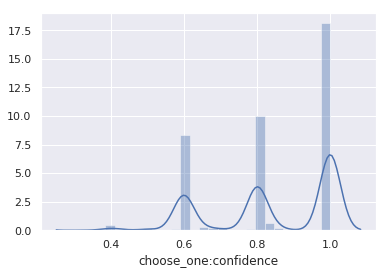

In [10]:
sns.distplot(sm['choose_one:confidence'])

In [11]:
sm['_last_judgment_at'].unique()[:5]
# looks like time when this was rated last? 

array([nan, '8/26/15 15:56', '8/28/15 19:14', '8/29/15 1:27',
       '8/26/15 16:31'], dtype=object)

In [12]:
dates = pd.to_datetime(sm['_last_judgment_at'])

In [13]:
dates.describe() # rated between one week 
# Any major events in this time period? Probably not

count                   10792
unique                    696
top       2015-08-27 16:12:00
freq                       72
first     2015-08-26 15:56:00
last      2015-09-02 23:38:00
Name: _last_judgment_at, dtype: object

#### Text

In [14]:
sm['text'].sort_values()

10517    ! Residents Return To Destroyed Homes As Washi...
2798     ! Sex-themed e-books given curfew in Germany o...
1383     # handbags Genuine Mulberry Antony Cross Body ...
8314     #360WiseNews : China's Stock Market Crash: Are...
8302     #360WiseNews : China's Stock Market Crash: Are...
8334     #360WiseNews : China's Stock Market Crash: Are...
8301     #360WiseNews : China's Stock Market Crash: Are...
8341     #360WiseNews : China's Stock Market Crash: Are...
8338     #360WiseNews : China's Stock Market Crash: Are...
8316     #360WiseNews : China's Stock Market Crash: Are...
1398     #3682 Nikon D50 6.1 MP Digital SLR Camera Body...
106      #3: Car Recorder ZeroEdgeå¨ Dual-lens Car Came...
7095     #3: TITAN WarriorCord 100 Feet - Authentic Mil...
4351     #3Novices : Renison mine sees seismic event ht...
3641     #4: The Hobbit: The Desolation of Smaug (Bilin...
1413     #7294 Nikon D50 6.1 MP Digital SLR Camera Body...
3106     #?? #?? #??? #??? MH370: Aircraft debris found.

#### Gold Standards

In [15]:
sm['_golden'].value_counts(dropna=False)

False    10792
True        84
Name: _golden, dtype: int64

In [16]:
sm['choose_one_gold'].value_counts(dropna=False) 
# 87 gold but only 84 True for _golden

NaN                           10789
Relevant                         57
Not Relevant                     24
Relevant\nCan't Decide            4
Not Relevant\nCan't Decide        2
Name: choose_one_gold, dtype: int64

In [17]:
sm[sm['choose_one_gold'] == "Relevant\nCan't Decide"]

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
9,778243834,True,golden,136,NaN,Relevant,0.9606,Relevant\nCan't Decide,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,21.0,NaN
13,778243838,True,golden,140,NaN,Relevant,0.9607,Relevant\nCan't Decide,NaN,NaN,I'm on top of the hill and I can see a fire in...,7.0,NaN
15,778243840,True,golden,147,NaN,Relevant,0.7177,Relevant\nCan't Decide,NaN,NaN,I'm afraid that the tornado is coming to our a...,9.0,NaN
19,778243844,True,golden,147,NaN,Relevant,0.6761,Relevant\nCan't Decide,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,24.0,NaN


In [18]:
sm[sm['choose_one_gold'] == "Not Relevant\nCan't Decide"]

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
42,778243871,True,golden,147,NaN,Not Relevant,1.0000,Not Relevant\nCan't Decide,NaN,NaN,No don't tell me that!,47.0,NaN
44,778243874,True,golden,134,NaN,Not Relevant,0.5945,Not Relevant\nCan't Decide,NaN,NaN,The end!,49.0,NaN


In [19]:
print(len(sm[(~sm['_golden']) & (sm['choose_one_gold'] == 'Relevant')])) # check length reveals this is the discrepancy
sm[(~sm['_golden']) & (sm['choose_one_gold'] == 'Relevant')] 

3


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
10841,778261075,False,golden,11,8/27/15 16:33,Not Relevant,0.6324,Relevant,NaN,NaN,Sirens everywhere!,235.0,NaN
10848,778261082,False,golden,14,8/27/15 16:20,Not Relevant,0.5696,Relevant,NaN,NaN,I just heard a really loud bang and everyone i...,7807.0,NaN
10861,778261095,False,golden,3,8/27/15 13:52,Not Relevant,0.6678,Relevant,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,242635.0,NaN


In [20]:
# Fix inconsistency
sm.loc[(~sm['_golden']) & (sm['choose_one_gold'] == 'Relevant'), '_golden'] = True 

In [21]:
# Q: How often is choose_one correct vs choose_one_gold? 

In [22]:
sm['choose_one'].value_counts()

Not Relevant    6187
Relevant        4673
Can't Decide      16
Name: choose_one, dtype: int64

In [23]:
(sm['choose_one'] == sm['choose_one_gold']).sum()

78

In [24]:
(sm.loc[sm['_golden'], 'choose_one'] == sm.loc[sm['_golden'], 'choose_one_gold']).sum() 
# Ratings from 78/87 gold standard comments are correct

78

In [25]:
# Where did they disagree?
sm.loc[sm['_golden']][(sm.loc[sm['_golden'], 'choose_one'] != sm.loc[sm['_golden'], 'choose_one_gold'])]
# Mostly the can't deicde's. 

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
9,778243834,True,golden,136,NaN,Relevant,0.9606,Relevant\nCan't Decide,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,21.0,NaN
13,778243838,True,golden,140,NaN,Relevant,0.9607,Relevant\nCan't Decide,NaN,NaN,I'm on top of the hill and I can see a fire in...,7.0,NaN
15,778243840,True,golden,147,NaN,Relevant,0.7177,Relevant\nCan't Decide,NaN,NaN,I'm afraid that the tornado is coming to our a...,9.0,NaN
19,778243844,True,golden,147,NaN,Relevant,0.6761,Relevant\nCan't Decide,NaN,NaN,#Flood in Bago Myanmar #We arrived Bago,24.0,NaN
42,778243871,True,golden,147,NaN,Not Relevant,1.0000,Not Relevant\nCan't Decide,NaN,NaN,No don't tell me that!,47.0,NaN
44,778243874,True,golden,134,NaN,Not Relevant,0.5945,Not Relevant\nCan't Decide,NaN,NaN,The end!,49.0,NaN
10841,778261075,True,golden,11,8/27/15 16:33,Not Relevant,0.6324,Relevant,NaN,NaN,Sirens everywhere!,235.0,NaN
10848,778261082,True,golden,14,8/27/15 16:20,Not Relevant,0.5696,Relevant,NaN,NaN,I just heard a really loud bang and everyone i...,7807.0,NaN
10861,778261095,True,golden,3,8/27/15 13:52,Not Relevant,0.6678,Relevant,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,242635.0,NaN


#### Keyword and Location

In [26]:
sm['keyword'].value_counts().head()
# probably the key word used to find each tweet 
# For OWL - shouldn't have to worry about keywords being used jokingly
# Can use these in text generation? 

military                50
electrocuted            50
structural%20failure    50
damage                  50
desolation              50
Name: keyword, dtype: int64

In [27]:
keywords = [s.replace('%20', ' ') for s in sm['keyword'].unique().tolist()[1:]] # remove nan

In [28]:
np.random.choice(keywords, 10)

array(['dead', 'explode', 'fire', 'bioterrorism', 'fatality', 'oil spill',
       'curfew', 'oil spill', 'fatalities', 'sirens'], dtype='<U19')

In [29]:
sm['location'].value_counts(dropna=False).head()

NaN              3638
USA               141
New York          109
United States      65
London             58
Name: location, dtype: int64

In [30]:
with pd.option_context('max_colwidth', -1):
    print(sm[sm['location'] == 'New York']['text'].head())
# Not sure how location is determined - tweet geo tag? 

228    See how a judge ruled in this 2009 accident at #JFK Airport? involving Korean Air?.\n\nhttp://t.co/Yh1cGlN3rl http://t.co/6F5ShPKjOB       
507    SHARK ARMY Black Date Stainless Steel Quartz Men Sport Watch - Full read by eBay http://t.co/k6OzC4wFQd http://t.co/H2ZC4nTdZN             
517    INFANTRY Mens Lume Dial Army Analog Quartz Wrist Watch Sport Blue Nylon Fabric  - Full reaÛ_ http://t.co/hEP9k0XgHb http://t.co/80EBvglmrA
528    WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEATHER WATCH WAR MIDO WW1 2 - Full read by eBay http://t.co/F9j3l2Yjl4 http://t.co/mwwWOWCayO  
540    WWI WWII JAPANESE ARMY NAVY MILITARY JAPAN LEATHER WATCH WAR MIDO WW1 2 - Full read by eBay http://t.co/QUmcE7W2tY http://t.co/KTKG2sDhHl  
Name: text, dtype: object


#### IDs

In [31]:
sm['tweetid'].value_counts(dropna=False).head()

6.290840e+17    197
6.290830e+17    190
6.290990e+17    166
6.290800e+17    157
6.290820e+17    152
Name: tweetid, dtype: int64

In [32]:
sm[sm['tweetid'].astype('str').str.contains('6.29084')]['tweetid'][547]

6.29084e+17

In [33]:
sm[sm['tweetid'] == 6.29084e+17].head()
# Tweetid 

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
547,778245363,False,finalized,5,8/28/15 7:33,Relevant,1.0000,NaN,arson,NaN,Cheesehead Report - Arson charges filed in Jac...,6.290840e+17,3.115227e+09
966,778245782,False,finalized,5,9/1/15 17:59,Not Relevant,1.0000,NaN,blaze,NaN,Craving slurpees ;-;,6.290840e+17,2.423798e+09
970,778245786,False,finalized,5,9/2/15 7:32,Relevant,0.8047,NaN,blaze,"Lithgow, NSW, Australia",Lithgow News: Homeless after blaze near Portla...,6.290840e+17,2.763639e+08
994,778245810,False,finalized,5,8/31/15 0:13,Not Relevant,0.8006,NaN,blazing,State of Georgia,@Blazing_Ben @PattyDs50 @gwfrazee @JoshuaAssar...,6.290840e+17,3.031839e+09
1036,778245852,False,finalized,5,8/27/15 17:05,Not Relevant,1.0000,NaN,bleeding,NaN,now my nose is bleeding. the last one was like...,6.290840e+17,3.561959e+08


In [34]:
sm['userid'].value_counts(dropna=False).head()

NaN              87
 1.370295e+09    26
 1.651824e+09    14
 1.732410e+09    14
 2.915192e+09    11
Name: userid, dtype: int64

In [35]:
sm[sm['userid'].astype('str').str.contains('1370295')]['userid'][6799]

1370295024.0

In [36]:
sm[sm['userid'] == 1370295024].head()
# all from same user and same message

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,choose_one,choose_one:confidence,choose_one_gold,keyword,location,text,tweetid,userid
6799,778251616,False,finalized,5,8/30/15 5:51,Not Relevant,0.5941,NaN,loud%20bang,Kenya,kabwandi_: Breaking news! Unconfirmed! I just ...,6.288590e+17,1.370295e+09
6800,778251617,False,finalized,5,8/27/15 16:35,Not Relevant,1.0000,NaN,loud%20bang,Kenya,tkyonly1fmk: Breaking news! Unconfirmed! I jus...,6.285760e+17,1.370295e+09
6804,778251621,False,finalized,5,8/27/15 18:25,Not Relevant,0.5957,NaN,loud%20bang,Kenya,Ercjmnea: Breaking news! Unconfirmed! I just h...,6.289120e+17,1.370295e+09
6805,778251622,False,finalized,5,8/30/15 11:13,Not Relevant,0.7982,NaN,loud%20bang,Kenya,iBliz140: Breaking news! Unconfirmed! I just h...,6.290330e+17,1.370295e+09
6807,778251624,False,finalized,5,8/30/15 4:36,Not Relevant,0.5965,NaN,loud%20bang,Kenya,kotolily_: Breaking news! Unconfirmed! I just ...,6.288740e+17,1.370295e+09


# Text Processing

In [37]:
nlp = spacy.load('en_core_web_sm')

In [38]:
%time spacy_docs = pd.Series(nlp.pipe(sm['text']))


CPU times: user 1min 13s, sys: 4.59 s, total: 1min 17s
Wall time: 51.2 s


In [39]:
spacy_docs.head()

0            (Just, happened, a, terrible, car, crash)
1    (Our, Deeds, are, the, Reason, of, this, #, ea...
2    (Heard, about, #, earthquake, is, different, c...
3    (there, is, a, forest, fire, at, spot, pond, ,...
4     (Forest, fire, near, La, Ronge, Sask, ., Canada)
dtype: object

In [40]:
# testing some spacy token attributes
# for token in spacy_docs[46]:
#     print(token.has_vector, token.is_quote, token.is_digit, token.like_url, token.like_email)

#### Things to Remove
\#  
token.like_url  
@...


In [41]:
# Samples 
pd.set_option('max_colwidth', -1)
pd.concat([spacy_docs[sm['choose_one'] == 'Relevant'].head(), spacy_docs[sm['choose_one'] == 'Relevant'].tail()], axis=0)

0        (Just, happened, a, terrible, car, crash)                                                                                                                                    
1        (Our, Deeds, are, the, Reason, of, this, #, earthquake, May, ALLAH, Forgive, us, all)                                                                                        
2        (Heard, about, #, earthquake, is, different, cities, ,, stay, safe, everyone, .)                                                                                             
3        (there, is, a, forest, fire, at, spot, pond, ,, geese, are, fleeing, across, the, street, ,, I, can, not, save, them, all)                                                   
4        (Forest, fire, near, La, Ronge, Sask, ., Canada)                                                                                                                             
10871    (M1.94, [, 01:04, UTC]?5, km, S, of, Volcano, Hawaii, ., http://t.co/zDtoyd8

In [42]:
# Golden standard tokens
spacy_docs[sm['_golden']].sample(5)

10850    (NWS, :, Flash, Flood, Warning, Continued, for, Shelby, County, until, 08:00, PM, Wednesday, ., http://t.co/nZ7ACKRrJi, #, tnwx)        
40       (Cooool, :))                                                                                                                            
10853    (Father, -, of, -, three, Lost, Control, of, Car, After, Overtaking, and, Collided, #, BathAndNorthEastSomerset, http://t.co/fa3FcnlN86)
10841    (Sirens, everywhere, !)                                                                                                                 
19       (#, Flood, in, Bago, Myanmar, #, We, arrived, Bago)                                                                                     
dtype: object

In [43]:
" ".join(wordninja.split(sm.loc[8, 'text']))

'Rocky Fire Update California Hwy 20 closed in both directions due to Lake County fire CA fire wildfires'

### What might be an OWL message look like?

In [44]:
owl_msg = 'Have a family of four stuck on the roof. Access by boat only. 12 year old child inmedical distress, missing insulin.'

In [45]:
%time " ".join(wordninja.split(owl_msg))

CPU times: user 1.04 ms, sys: 0 ns, total: 1.04 ms
Wall time: 1.05 ms


'Have a family of four stuck on the roof Access by boat only 12 year old child in medical distress missing insulin'

### To do: Create Terminology Lists
1. Medicine list 
2. house features?
3. Child

In [46]:
owl_doc = nlp(" ".join(wordninja.split(owl_msg)))

In [47]:
owl_doc.ents

(four, Access, 12 year old)

In [48]:
for ent in owl_doc.ents:
    print(ent, ent.label_)
# default ent recognition not too helpful

four CARDINAL
Access PRODUCT
12 year old DATE


In [49]:
# displacy.serve(owl_doc, style='dep')

### Most common words

In [50]:
def dummy(doc):
    "already preprocessed input"
    return doc

def to_list(doc):
    "return as list of tokens"
    return [token.text for token in doc]


In [51]:
tv = TfidfVectorizer(
    stop_words=STOP_WORDS.union(set(string.punctuation)),
    tokenizer=to_list,
    preprocessor=dummy,
    max_df=0.90, 
    min_df=2
)  

tv.fit(spacy_docs[sm['choose_one'] == 'Relevant'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.9, max_features=None,
                min_df=2, ngram_range=(1, 1), norm='l2',
                preprocessor=<function dummy at 0x7f12bfbbe7b8>,
                smooth_idf=True,
                stop_words={'!', '"', '#', '$', '%', '&', "'", "'d", "'ll",
                            "'m", "'re", "'s", "'ve", '(', ')', '*', '+', ',',
                            '-', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                            '[', '\\', ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<function to_list at 0x7f12bfbbe9d8>, use_idf=True,
                vocabulary=None)

In [52]:
tv_bow = tv.transform(spacy_docs[sm['choose_one'] == 'Relevant'])


In [53]:
tv_bow.shape

(4673, 5319)

In [54]:
sum_words_def = tv_bow.sum(axis=0)
word_freqs_def = [(word, sum_words_def[0, idx]) for word, idx in tv.vocabulary_.items()] # map token back to its word
word_freqs_def = sorted(word_freqs_def, key=lambda x: x[1], reverse=True) # sort by most common
top_words_def = word_freqs_def[20:50]
top_words_def

[('crash', 24.28098628252701),
 ('disaster', 23.865055903622256),
 ('bombing', 23.800676177811706),
 ('buildings', 23.5048945826562),
 ('Northern', 22.91487124969396),
 ('\n\n', 22.684144623914076),
 ('This', 22.549577277335334),
 ('bomb', 22.409516348577476),
 ('attack', 22.255553650494278),
 ('storm', 21.622642900667024),
 ('We', 21.507152589062468),
 ('..', 21.393980401508365),
 ('Legionnaires', 20.886619742384138),
 ('burning', 20.69105828144166),
 ('bomber', 20.589469737269663),
 ('police', 20.52925947298368),
 ('PM', 20.250780387762187),
 ('train', 20.185028868053905),
 ('mass', 20.174310069743882),
 ('RT', 20.1629917250109),
 ('It', 19.9566713678492),
 ('Japan', 19.326452520500492),
 ('Malaysia', 19.26115079810518),
 ('families', 19.057592017210233),
 ('Obama', 18.77728370949394),
 ('fatal', 18.727350222884727),
 ('Disaster', 18.041585780065994),
 ('nuclear', 17.744342036766128),
 ('Fire', 17.714281260814253),
 ('old', 17.6543435544052)]

<a id='paired'></a>
# 2. Paired Terms Data

In [55]:
pt = pd.read_csv('./data/paired_terms_disaster_relef.csv')

In [56]:
pt['relevance'].describe() # a ranking from 1 to 5

count    18128.000000
mean     3.629188    
std      0.763086    
min      1.000000    
25%      3.330000    
50%      4.000000    
75%      4.000000    
max      5.000000    
Name: relevance, dtype: float64

In [57]:
pt['_trusted_judgments'].value_counts().head()

3    16016
4    1764 
5    249  
6    23   
7    9    
Name: _trusted_judgments, dtype: int64

In [58]:
pt.sample(5).T

,15040,2055,14634,14338,2587
_unit_id,879654077,867853261,879653071,879652688,867853813
_golden,False,False,False,False,False
_unit_state,finalized,finalized,finalized,finalized,finalized
_trusted_judgments,3,3,3,3,4
_last_judgment_at,2/16/2016 14:04:53,1/29/2016 15:19:39,2/14/2016 18:43:25,2/15/2016 22:30:24,1/29/2016 20:34:11
is_the_term,a_specific_person_or_place,NaN,misspelled_or_ungrammatical,NaN,a_specific_person_or_place
is_the_term:confidence,1,NaN,1,NaN,1
relevance,4,4,4,2.33,4.5
relevance:variance,0.816,0,0,0.943,0.5
definition,"Any humanitarian crisis or natural disaster situation involving sanitation disruption, including lack of waste removal, sewage problems, etc.","Any humanitarian crisis or natural disaster situation involving shelter availability, including destruction of homes, unsafe shelter conditions, etc.","Any situation involving violent unrest including riots, insurgencies, looting, etc. or any wide-spread criminal activity","Any humanitarian crisis or natural disaster situation involving water supply, including lack of water, contamination of water, etc.","Any humanitarian crisis or natural disaster situation involving food supply, including lack of food/food sources."


In [59]:
pt['term'].value_counts(dropna=False).head() # not all terms are relevant

BIRTHDAY PARTY           26
MUSIC LIBRARY            23
MICROSOFT EXCEL          20
HYDROPOWER FACILITIES    19
FLAVORED TOBACCO         18
Name: term, dtype: int64

In [60]:
pt.groupby('topic')['term'].nunique()

topic
Elections and Politics          1326
Energy                          1319
Evacuation                      1247
Extreme Violence, Terrorism     1284
Food                            1278
Infrastructure and Utilities    1123
Intervention                    1277
Medical                         1353
Sanitation                      1006
Search and Rescue               1338
Shelter                         1092
Violent Civil Unrest            1278
Water                           1325
Name: term, dtype: int64

In [61]:
pt[(pt['topic'] == 'Evacuation') & (pt['relevance'] > 3)]['term'].unique()[:10]
# 902 unique for evacuation

array(['ORDERED DEPARTURE', 'UNHINDERED HUMANITARIAN', 'FLOOD DEBRIS',
       'TRIAGE TENT', 'MILITARISED FRONTIER', 'REPATRIATING REFUGEES',
       'RELIEVE OVERCROWDING', 'INTERNALLY DISPLACED PEOPLES',
       'MEDEVAC SYSTEM', 'ONWARD DELIVERY'], dtype=object)

In [62]:
medical_terms = pt[(pt['topic'] == 'Medical')  & (pt['relevance'] > 3)]['term'].unique().tolist()
medical_terms[:20] # could be a nice list if someone ticks the MEDICAL label in OWL and specifies what disease or what medication they need

['PSYCHIATRIC TREATMENT',
 'VISCERAL LEISHMANIASIS',
 'UNEXPLAINED FEVER',
 'PNEUMONIA PATIENTS',
 'ACUTE RESPIRATORY DISTRESS',
 'PAIN MEDICATION',
 'MEASLES EPIDEMICS',
 'ARSENIC POISONING',
 'ORAL POLIO VACCINATION',
 'MENINGOCOCCAL DISEASE',
 'DIARRHOEAL DISEASE OUTBREAKS',
 'LETHAL DISEASE',
 'MOSQUITO-BORNE VIRUS',
 'GRADE FEVER',
 'LUNG INFECTIONS',
 'UNDIAGNOSED DISEASE',
 'INPATIENT TREATMENT',
 'CENTERS FOR DISEASE CONTROL',
 'SEPTICEMIA',
 'WHOOPING COUGH OUTBREAK']

In [63]:
# with open('paired_medical_terms.pkl', 'wb') as picklefile:
#     pickle.dump(medical_terms, picklefile)

In [64]:
print(len(pt[(pt['topic'] == 'Shelter')  & (pt['relevance'] > 3)]['term'].unique()))

914


<a id='relief'></a>
# 3. Disaster relief 
Another term to topic relevance annotation. May have some overlap with previous but an interesting exercise parsing a messy csv file. 

In [65]:
# !sed -i "s/, / /g" data/disaster-relief-dfe-854578.csv 
# deal with commas within a field, noting that delimiter commas don't have a space 

In [66]:
# Approach 1: naive pandas read
dr = pd.read_csv('./data/disaster-relief-dfe-854578.csv', encoding='latin-1') # a simple encoding to ignore complex characters
dr.columns

Index(['#NAME?', '#NAME?.1', '#NAME?.2', '#NAME?.3', '#NAME?.4',
       'is+AF8-the+AF8-term', 'is+AF8-the+AF8-term:confidence', 'relevance',
       'relevance:variance', 'definition', 'dist', 'example', 'freq', 'id',
       'is+AF8-the+AF8-term+AF8-gold', 'len', 'relevance+AF8-gold', 'search',
       'seed', 'term', 'topic', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39',
       'Unnamed: 40', 'Unnamed: 41'],
      dtype='object')

In [67]:
dr.head().T
# commas too inconsistent

,0,1,2,3,4
#NAME?,867405675,5+ACI-,867405676,5+ACI-,867405677
#NAME?.1,TRUE,https://www.google.com/search?q+AD0AJQ-22WATER+ACU-20SHORTAGES+ACU-22,TRUE,https://www.google.com/search?q+AD0AJQ-22VACCINATION+ACU-20CAMPAIGNS+ACU-22,TRUE
#NAME?.2,golden,0,golden,0,golden
#NAME?.3,119,WATER SHORTAGES,120,VACCINATION CAMPAIGNS,123
#NAME?.4,NaN,Animal Management,NaN,Epidemic,NaN
is+AF8-the+AF8-term,a+AF8-specific+AF8-person+AF8-or+AF8-place,NaN,a+AF8-specific+AF8-person+AF8-or+AF8-place,NaN,a+AF8-specific+AF8-person+AF8-or+AF8-place
is+AF8-the+AF8-term:confidence,1,NaN,1,NaN,1
relevance,3.05,NaN,4.33,NaN,3.53
relevance:variance,1.068,NaN,0.61,NaN,0.99
definition,#NAME? living missing displaced or injured/dead in relation to a humanitarian crisis or natural disaster situation.+ACI-,NaN,Any situation involving widespread outbreak of infectious disease.,NaN,Services needed or offered by volunteers or professionals in a humanitarian crisis or natural disaster situation.


In [68]:
# Approach 2: parse by line
records = []
with open('./data/disaster-relief-dfe-854578.csv', 'rt') as file:
    for r in file:
        tokens = r.replace('\n', '').replace('#NAME?', '.').strip(',').split(',') 
        if 'finalized' in tokens:
            values = (tokens[7], tokens[8], tokens[-2], tokens[-1])
            records.append(values)


In [69]:
terms = pd.DataFrame(records, columns=['relevance', 'relevance:variance', 'term', 'topic']) 
# columns 7, 8, -2, -1 respectively once strip removes the trailing commas
# did skip some rows that overflowed to two lines within file using the 'finalized' condition

In [70]:
# clean up characters like '+ACI-' and lower case for consistency
terms['topic'] = terms['topic'].str.replace(r'\+.+-', ' ').str.replace('\.', ' ').str.strip().str.lower()
terms['term'] = terms['term'].str.replace(r'\+.+-', ' ').str.replace('\.', ' ').str.strip().str.lower() 

In [71]:
terms.shape

(7510, 4)

In [72]:
# not all terms are relevant
terms.sort_values('relevance').head()

,relevance,relevance:variance,term,topic
3480,1,0,wedding arrangements,evacuation
2150,1,0,birthday party,medical
784,1,0,grammy awards,energy
3363,1,0,handmade desk,search rescue
6851,1,0,paper recycling,evacuation


In [73]:
# check distribution
terms['relevance'].value_counts()

4       2308
4.33    2110
4.67    845 
3.67    615 
3.33    563 
3       318 
5       178 
2.67    154 
2       113 
2.33    112 
1.33    78  
1       66  
1.67    50  
Name: relevance, dtype: int64

/home/douglas/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


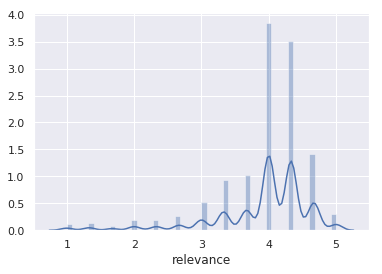

In [74]:
sns.distplot(terms['relevance'].astype('float'))

In [75]:
# relevance of 3 was a reasonale cut off point for irrelevant terms
relevant = terms[terms['relevance'].astype('float') > 3]
print(relevant.shape)
relevant.head()

(6619, 4)


,relevance,relevance:variance,term,topic
0,4,0,river basin,water
1,4,0,power supply,energy
2,4.33,0.471,field hospitals,search and rescue
3,4,0,sales force,elections
4,4.33,0.471,severely injured,search and rescue


In [76]:
print(f'{relevant["topic"].nunique()} topics')
relevant['topic'].value_counts()

18 topics


elections and politics          547
medical                         542
terrorism                       528
food                            525
violent civil unrest            523
infrastructure and utilities    520
water                           518
intervention                    513
shelter                         500
sanitation                      494
search and rescue               493
evacuation                      489
energy                          412
violent unrest                  4  
search rescue                   3  
extreme violence                3  
infrastructure                  3  
elections                       2  
Name: topic, dtype: int64

In [77]:
# Try out differnet ways to consolidate the topics
# all were roughly the same speed
topic_map_dict = {'violent unrest': 'violent civil unrest', 
                  'infrastructure':'infrastructure and utilities', 
                  'search rescue': 'search and rescue',
                  'elections':'elections and politics'}

def map_topics(topic):
    '''Update values for '''
    if topic in topic_map_dict.keys():
        return topic_map_dict[topic]
    else:
        return topic

In [78]:
%timeit relevant['topic'] = relevant['topic'].map(map_topics)

/home/douglas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


95.9 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [79]:
%timeit relevant['topic'] = relevant['topic'].map(topic_map_dict).fillna(relevant['topic'])

/home/douglas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


103 ms ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [80]:
%timeit relevant['topic'] = relevant['topic'].replace(topic_map_dict)

/home/douglas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


105 ms ± 6.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [81]:
relevant['topic'].value_counts()

elections and politics          549
medical                         542
terrorism                       528
violent civil unrest            527
food                            525
infrastructure and utilities    523
water                           518
intervention                    513
shelter                         500
search and rescue               496
sanitation                      494
evacuation                      489
energy                          412
extreme violence                3  
Name: topic, dtype: int64

In [82]:
np.random.choice(relevant[relevant['topic']=='water']['term'].unique(), 10)

array(['potentially contaminated', 'bathing places', 'salty water',
       'poor drainage system', 'boreholes', 'pump wells', 'turbid',
       'piping', 'through portable tankers', 'drinking water supplies'],
      dtype=object)

In [83]:
# print a bunch of the terms for each topic
# relevant.groupby('topic')['term'].unique()

# Takeaway 
Exploring these data sets were useful to get more familiar with the vocabulary used when dealing with natural disasters and will help in generating terminology lists to catch keywords that might show up in an OWL message. However, the context for these are not the best fit for our current task of generating and parsing potentia OWL help requests due to the generality and formality of some of the topics.

I explore more personal tweets in [EDA]Hurricane_Harvey and work on matching against terminology lists in [EDA]Phrase_matcher.